In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
#models
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

### f1 & accuracy for models on stroke prediction dataset

In [11]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print("all rows: ", df.shape[0])
print(f"#stroke values: {sum(df['stroke'] == 1)}; #no stroke values: {sum(df['stroke'] == 0)}")

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

all rows:  4909
#stroke values: 209; #no stroke values: 4700


In [36]:
def randomforest():
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    return rf_model.predict(X_test_scaled)

def xgboost():
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train_scaled, y_train)
    return bst.predict(X_test_scaled)

def adaboost():
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train_scaled, y_train)
    return ada.predict(X_test_scaled)

def svm_model():
    model = svm.SVC(kernel='linear', probability=True, random_state=42)
    model.fit(X_train_scaled, y_train)
    model.predict(X_test)
    return model.predict(X_test_scaled)

def mlp():
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        max_iter=2000,
        random_state=42,
        early_stopping=True
    )
    mlp.fit(X_train_scaled, y_train)
    return mlp.predict(X_test_scaled)

def confusionMatrix(prediction, model_name, ax):
    cm = confusion_matrix(y_test, prediction, labels=[0,1])
    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)

    accuracy = accuracy_score(prediction, y_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
    disp.plot(ax=ax, colorbar=True)
    ax.set_title(f"{model_name}\nF1: {f1_score:.2f}, Acc: {accuracy:.2f}")
    return f1_score, accuracy

/tmp/ipykernel_4407/1301848859.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_4407/1301848859.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_4407/1301848859.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)
/tmp/ipykernel_4407/1301848859.py:40: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


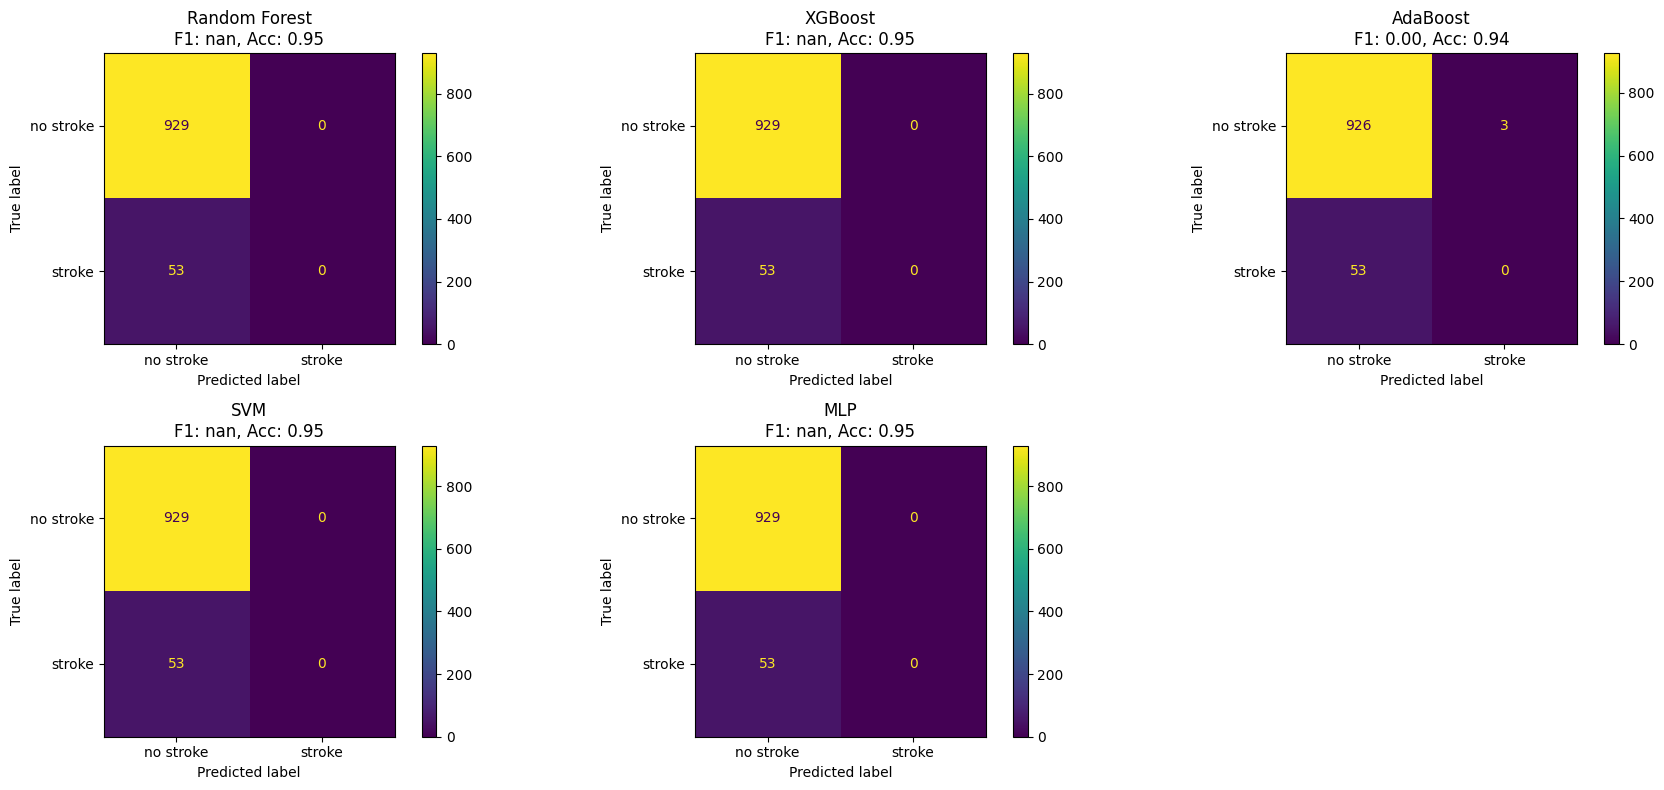

In [37]:
 models = {
    "Random Forest": randomforest(),
    "XGBoost": xgboost(),
    "AdaBoost": adaboost(),
    "SVM": svm_model(),
    "MLP": mlp()
}

# Subplots: 2 Zeilen, 3 Spalten
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # 2D → 1D für einfaches Iterieren

# Plots füllen
for i, (name, prediction) in enumerate(models.items()):
    confusionMatrix(prediction, name, axes[i])

# Letztes leeres Feld ausschalten, falls weniger als 6 Modelle
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### + weight balancing

In [38]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print(sum(df['stroke'] == 1), sum(df['stroke'] == 0))

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

print(sum(y_train == 1), sum(y_train == 0))

209 4700
156 3771


In [39]:
def randomforest():
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=5, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    return rf_model.predict(X_test_scaled)

def xgboost():
    neg = sum(y_train == 0)
    pos = sum(y_train == 1)
    scale_pos_weight = neg / pos

    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', scale_pos_weight=scale_pos_weight)
    bst.fit(X_train_scaled, y_train)
    return bst.predict(X_test_scaled)

def adaboost():
    class_weight = {0: 1.0, 1: sum(y_train == 0) / sum(y_train == 1)}
    weight = y_train.map(class_weight)

    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train_scaled, y_train, sample_weight=weight)
    return ada.predict(X_test_scaled)

def svm_model():
    model = svm.SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    model.fit(X_train_scaled, y_train)
    model.predict(X_test)
    return model.predict(X_test_scaled)

def mlp():
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        max_iter=2000,
        random_state=42,
        early_stopping=True
    )
    mlp.fit(X_train_scaled, y_train)
    return mlp.predict(X_test_scaled)

def confusionMatrix(prediction, model_name, ax):
    cm = confusion_matrix(y_test, prediction, labels=[0,1])
    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)

    accuracy = accuracy_score(prediction, y_test)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
    disp.plot(ax=ax, colorbar=True)
    ax.set_title(f"{model_name}\nF1: {f1_score:.2f}, Acc: {accuracy:.2f}")
    return f1_score, accuracy

/tmp/ipykernel_4407/222978206.py:47: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


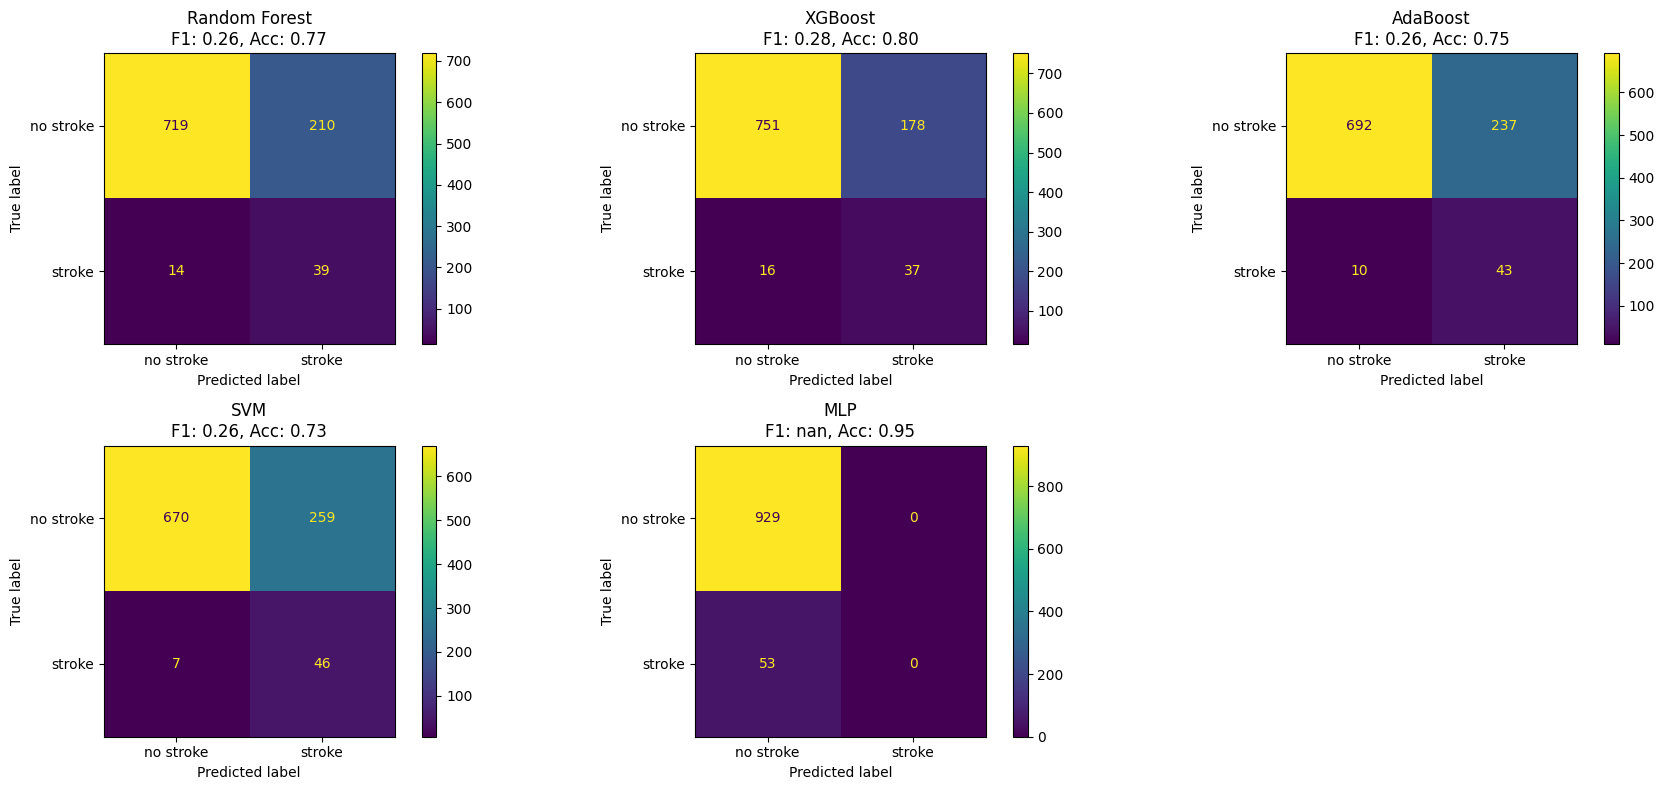

In [40]:
 models = {
    "Random Forest": randomforest(),
    "XGBoost": xgboost(),
    "AdaBoost": adaboost(),
    "SVM": svm_model(),
    "MLP": mlp()
}

# Subplots: 2 Zeilen, 3 Spalten
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # 2D → 1D für einfaches Iterieren

# Plots füllen
for i, (name, prediction) in enumerate(models.items()):
    confusionMatrix(prediction, name, axes[i])

# Letztes leeres Feld ausschalten, falls weniger als 6 Modelle
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### + smote (Synthetic Minority Oversampling Technique)

In [13]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print(f"training data without smote: #stroke values: {sum(y_train == 1)} #no stroke values: {sum(y_train == 0)}")

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test_scaled, y_test)

print(f"training data with smote: #stroke values: {sum(y_train_res == 1)} #no stroke values: {sum(y_train_res == 0)}")

training data without smote: #stroke values: 156 #no stroke values: 3771
training data with smote: #stroke values: 3771 #no stroke values: 3771


In [42]:
def randomforest():
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train_res, y_train_res)
    return rf_model.predict(X_test_res)

def xgboost():
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train_res, y_train_res)
    return bst.predict(X_test_res)

def adaboost():
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train_res, y_train_res)
    return ada.predict(X_test_res)

def svm_model():
    model = svm.SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    model.fit(X_train_res, y_train_res)
    model.predict(X_test)
    return model.predict(X_test_res)

def mlp():
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        max_iter=2000,
        random_state=42,
        early_stopping=True
    )
    mlp.fit(X_train_res, y_train_res)
    return mlp.predict(X_test_res)

def confusionMatrix(prediction, model_name, ax):
    cm = confusion_matrix(y_test_res, prediction, labels=[0,1])
    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(prediction, y_test_res)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
    disp.plot(ax=ax, colorbar=True)
    ax.set_title(f"{model_name}\nF1: {f1_score:.2f}, Acc: {accuracy:.2f}")
    return f1_score, accuracy

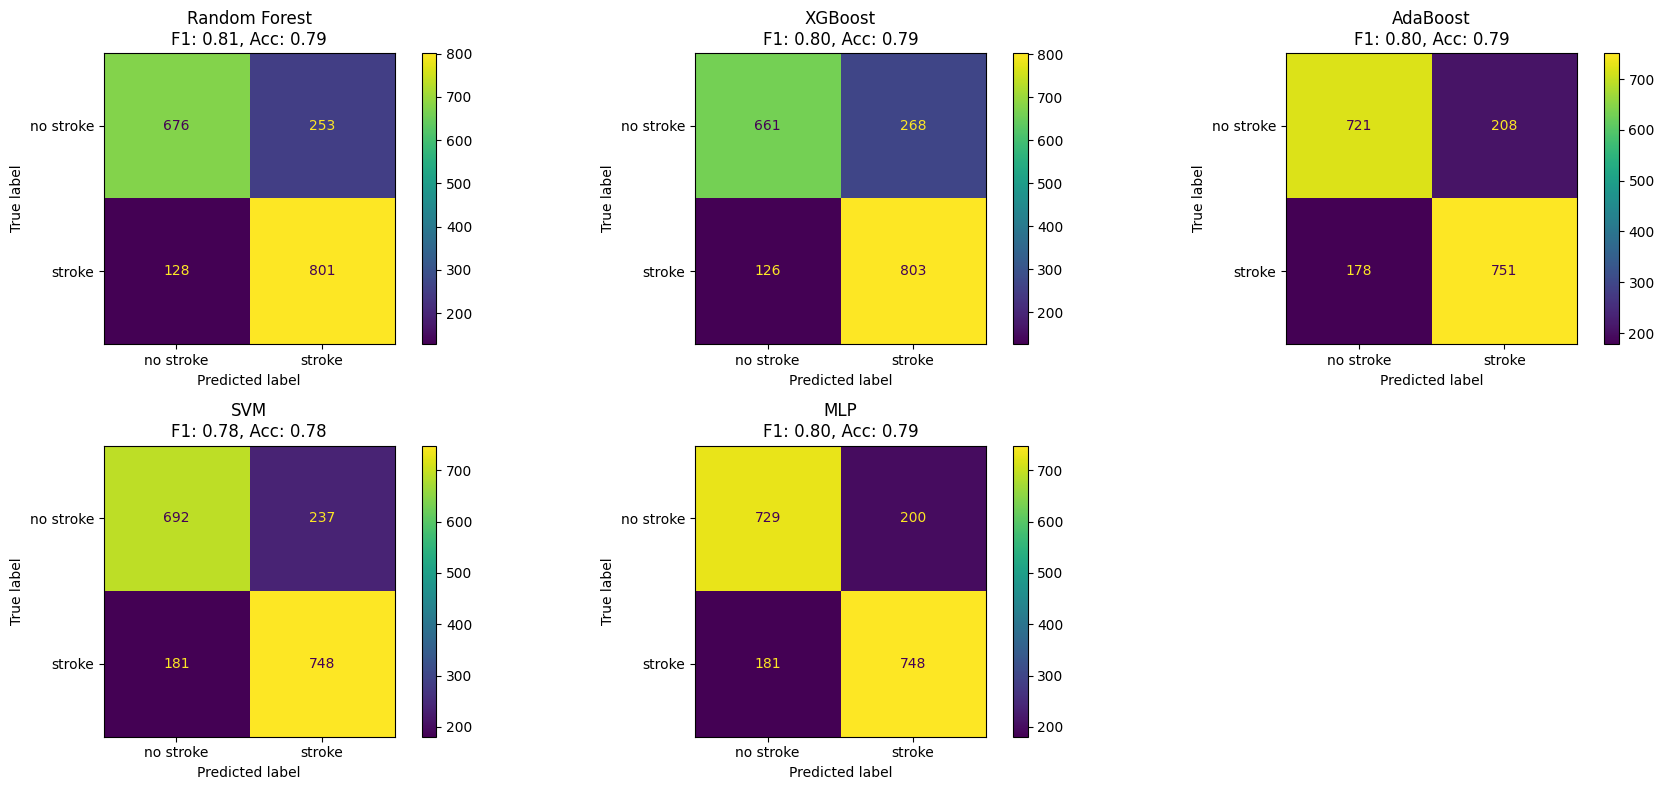

In [43]:
 models = {
    "Random Forest": randomforest(),
    "XGBoost": xgboost(),
    "AdaBoost": adaboost(),
    "SVM": svm_model(),
    "MLP": mlp()
}

# Subplots: 2 Zeilen, 3 Spalten
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # 2D → 1D für einfaches Iterieren

# Plots füllen
for i, (name, prediction) in enumerate(models.items()):
    confusionMatrix(prediction, name, axes[i])

# Letztes leeres Feld ausschalten, falls weniger als 6 Modelle
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### + smote & weight balancing

In [44]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print(sum(df['stroke'] == 1), sum(df['stroke'] == 0))

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test_scaled, y_test)

print(sum(y_train_res == 1), sum(y_train_res == 0))

209 4700
3771 3771


In [45]:
def randomforest():
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train_res, y_train_res)
    return rf_model.predict(X_test_res)

def xgboost():
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train_res, y_train_res)
    return bst.predict(X_test_res)

def adaboost():
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train_res, y_train_res)
    return ada.predict(X_test_res)

def svm_model():
    model = svm.SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    model.fit(X_train_res, y_train_res)
    model.predict(X_test)
    return model.predict(X_test_res)

def mlp():
    mlp = MLPClassifier(hidden_layer_sizes=(100,),  # 1 versteckte Schicht mit 100 Neuronen
                    activation='relu',
                    solver='adam',
                    max_iter=1000,
                    random_state=42)
    mlp.fit(X_train_res, y_train_res)
    return mlp.predict(X_test_res)

def confusionMatrix(prediction, model_name, ax):
    cm = confusion_matrix(y_test_res, prediction, labels=[0,1])
    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(prediction, y_test_res)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{model_name}\nF1: {f1_score:.2f}, Acc: {accuracy:.2f}")
    return f1_score, accuracy

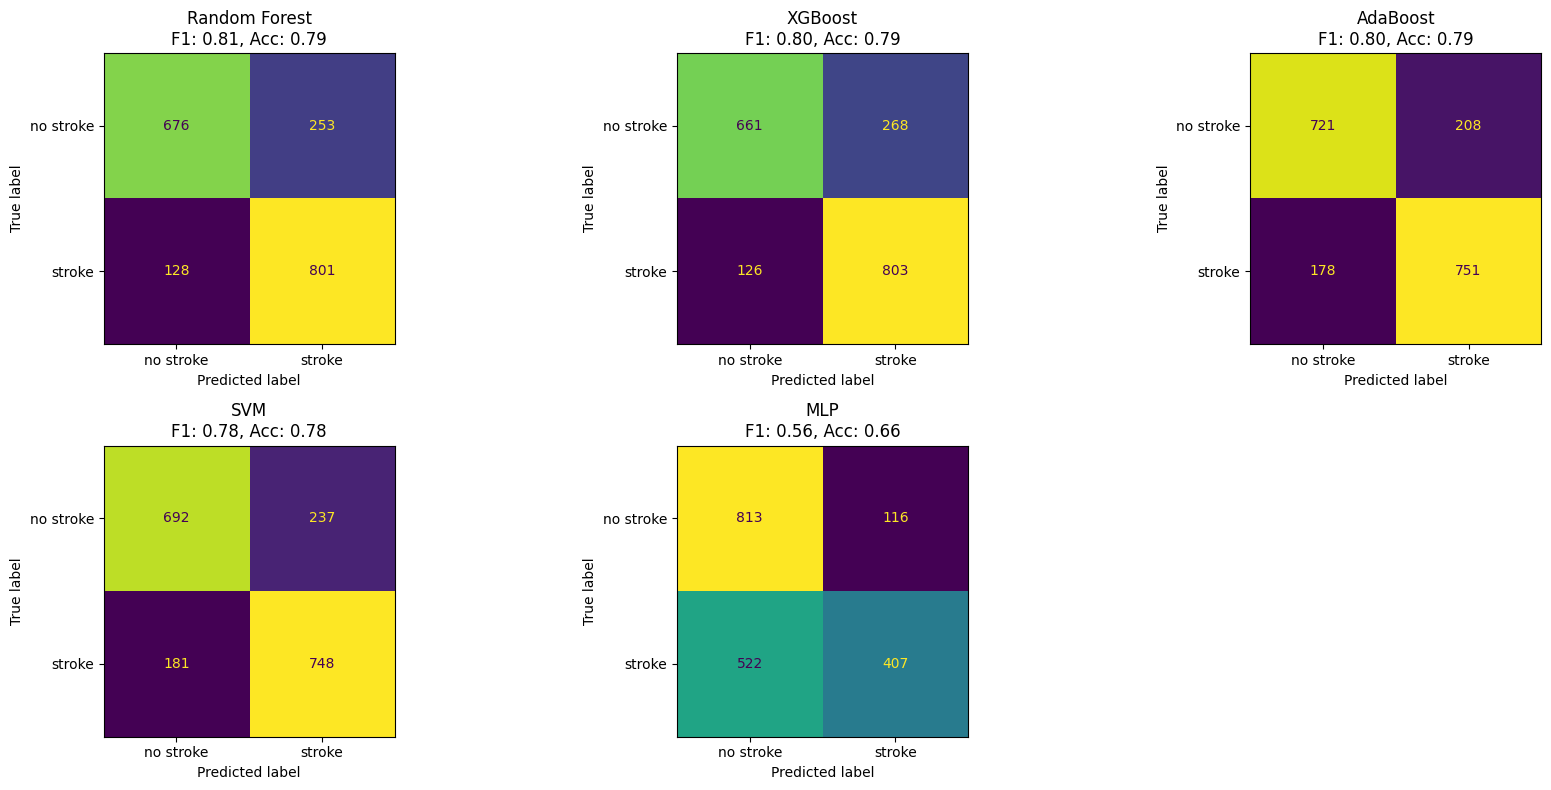

In [46]:
 models = {
    "Random Forest": randomforest(),
    "XGBoost": xgboost(),
    "AdaBoost": adaboost(),
    "SVM": svm_model(),
    "MLP": mlp()
}

# Subplots: 2 Zeilen, 3 Spalten
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # 2D → 1D für einfaches Iterieren

# Plots füllen
for i, (name, prediction) in enumerate(models.items()):
    confusionMatrix(prediction, name, axes[i])

# Letztes leeres Feld ausschalten, falls weniger als 6 Modelle
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Results

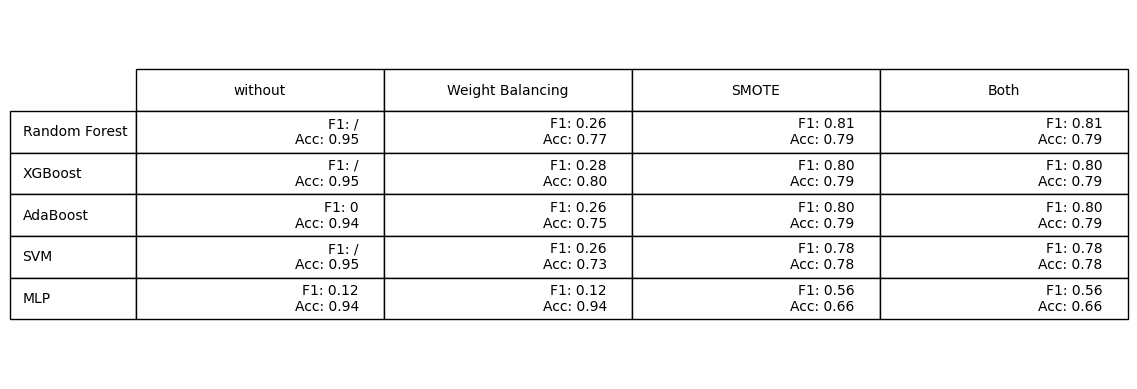

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

row_labels = ['Random Forest', 'XGBoost', 'AdaBoost', 'SVM', 'MLP']
col_labels = ['without','Weight Balancing', 'SMOTE', 'Both']

table_vals = [
    ['F1: /\nAcc: 0.95' ,'F1: 0.26\nAcc: 0.77', 'F1: 0.81\nAcc: 0.79', 'F1: 0.81\nAcc: 0.79'],
    ['F1: /\nAcc: 0.95','F1: 0.28\nAcc: 0.80', 'F1: 0.80\nAcc: 0.79', 'F1: 0.80\nAcc: 0.79'],
    ['F1: 0\nAcc: 0.94','F1: 0.26\nAcc: 0.75', 'F1: 0.80\nAcc: 0.79', 'F1: 0.80\nAcc: 0.79'],
    ['F1: /\nAcc: 0.95','F1: 0.26\nAcc: 0.73', 'F1: 0.78\nAcc: 0.78', 'F1: 0.78\nAcc: 0.78'],
    ['F1: 0.12\nAcc: 0.94','F1: 0.12\nAcc: 0.94', 'F1: 0.56\nAcc: 0.66', 'F1: 0.56\nAcc: 0.66'],
]

# Tabelle zeichnen
the_table = plt.table(cellText=table_vals,
                      colWidths=[0.2] * 4,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='center')

# Styling
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(2.5, 2.5)

# Achsen ausblenden
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.show()


### further metrics (smote)

In [48]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print(sum(df['stroke'] == 1), sum(df['stroke'] == 0))

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test_scaled, y_test)

print(sum(y_train_res == 1), sum(y_train_res == 0))
print(sum(y_test_res == 1), sum(y_test_res == 0))

209 4700
3771 3771
929 929


In [49]:
def randomforest():
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    rf_model.fit(X_train_res, y_train_res)
    return rf_model.predict(X_test_res)

def xgboost():
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train_res, y_train_res)
    return bst.predict(X_test_res)

def adaboost():
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train_res, y_train_res)
    return ada.predict(X_test_res)

def svm_model():
    model = svm.SVC(kernel='linear', probability=True, random_state=42, class_weight='balanced')
    model.fit(X_train_res, y_train_res)
    model.predict(X_test)
    return model.predict(X_test_res)

def mlp():
    mlp = MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        alpha=0.01,
        learning_rate_init=0.001,
        max_iter=2000,
        random_state=42,
        early_stopping=True
    )
    mlp.fit(X_train_res, y_train_res)
    return mlp.predict(X_test_res)

def confusionMatrix(prediction, model_name, ax):
    cm = confusion_matrix(y_test_res, prediction, labels=[0,1])
    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if precision + recall == 0:
        f1_score = 0.0
    else:
        f1_score = 2 * precision * recall / (precision + recall)
    accuracy = accuracy_score(prediction, y_test_res)
    roc_auc = roc_auc_score(y_test_res, prediction)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
    disp.plot(ax=ax, colorbar=True)
    ax.set_title(f"{model_name}\nF1: {f1_score:.2f}, Acc: {accuracy:.2f},\n AUC: {roc_auc:.2f}")
    return f1_score, accuracy

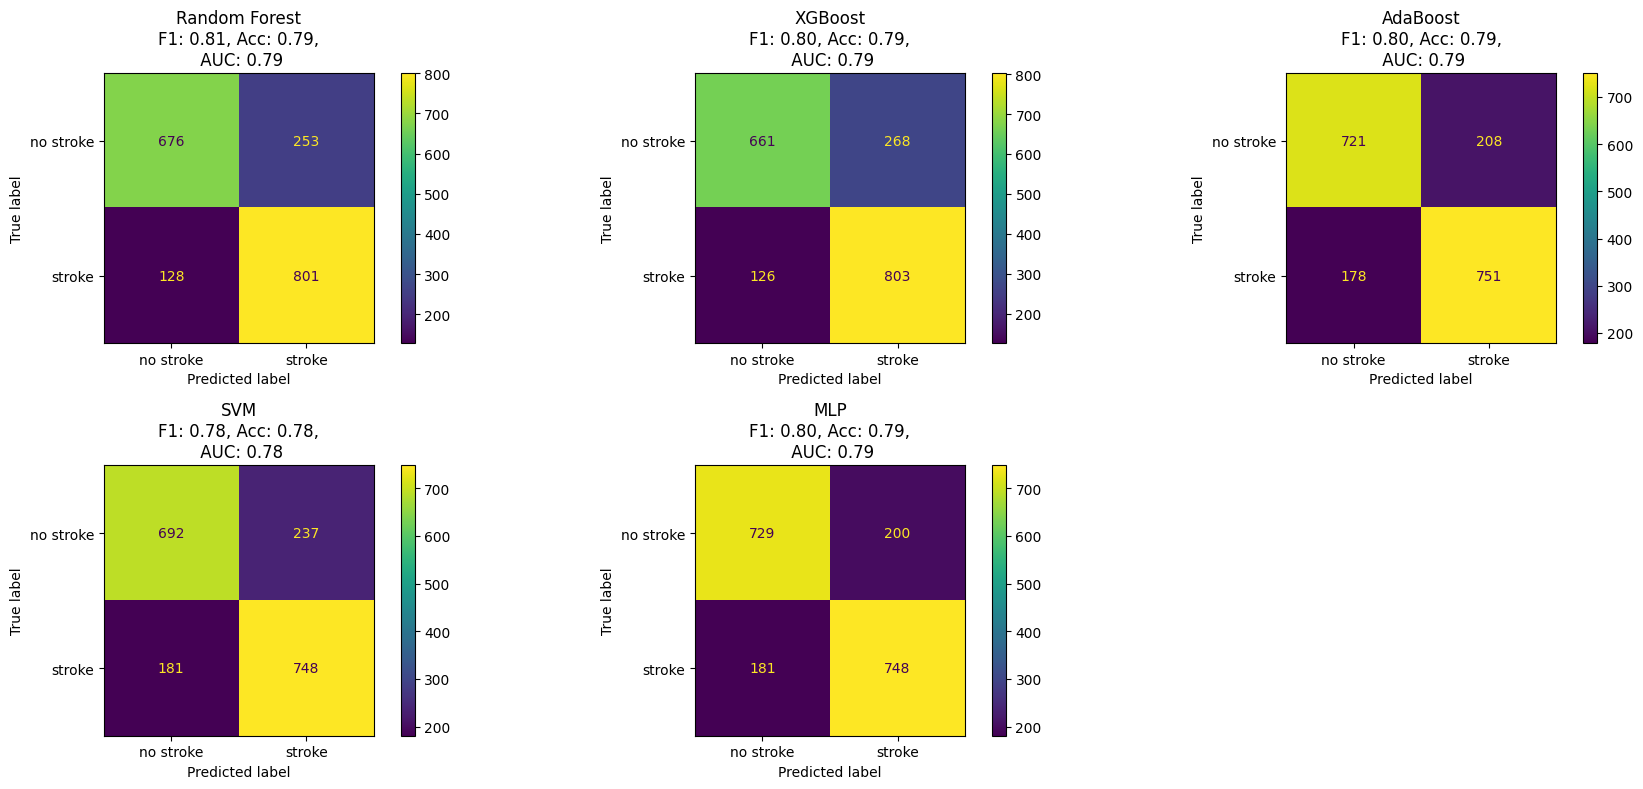

In [50]:
 models = {
    "Random Forest": randomforest(),
    "XGBoost": xgboost(),
    "AdaBoost": adaboost(),
    "SVM": svm_model(),
    "MLP": mlp()
}

# Subplots: 2 Zeilen, 3 Spalten
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()  # 2D → 1D für einfaches Iterieren

# Plots füllen
for i, (name, prediction) in enumerate(models.items()):
    confusionMatrix(prediction, name, axes[i])

# Letztes leeres Feld ausschalten, falls weniger als 6 Modelle
for j in range(len(models), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### fine tuning mlp

In [51]:
df = pd.read_csv('../healthcare-dataset-stroke-data.csv', sep=',', header=0)
feature_names = df.columns.tolist()
df = df.dropna(subset=['bmi']).reset_index(drop=True)

print(sum(df['stroke'] == 1), sum(df['stroke'] == 0))

X = df.drop(['id','stroke'], axis=1)
y = df['stroke']

X['gender'] = X['gender'].map({'Female': 0, 'Male': 1, 'Other': 2})
X['ever_married'] = X['ever_married'].map({'No': 0, 'Yes': 1})
X['work_type'] = X['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X['Residence_type'] = X['Residence_type'].map({'Urban': 0, 'Rural': 1})
X['smoking_status'] = X['smoking_status'].map({'never smoked': 0, 'formerly smoked': 1, 'smokes': 2, 'Unknown' : 3})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numerical_columns = ['age', 'avg_glucose_level', 'bmi']

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
X_test_res, y_test_res = smote.fit_resample(X_test_scaled, y_test)

print(sum(y_train_res == 1), sum(y_train_res == 0))
print(sum(y_test_res == 1), sum(y_test_res == 0))

209 4700
3771 3771
929 929


In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay


def optimize_mlp_manually(X_train, y_train, X_test, y_test):
    """
    Schrittweise manuelle Optimierung
    """
    best_f1 = 0
    best_params = {}
    results = []

    # Verschiedene Architekturen testen
    architectures = [
        (50,), (100,), (150,), (200,),
        (100, 50), (150, 75), (200, 100),
        (100, 50, 25), (150, 100, 50)
    ]

    # Alpha-Werte (Regularisierung)
    alphas = [1e-5, 1e-4, 1e-3, 1e-2]

    # Learning rates
    learning_rates = [0.001, 0.005, 0.01, 0.05]

    print("Teste verschiedene Konfigurationen...")

    for arch in architectures:
        for alpha in alphas:
            for lr in learning_rates:
                mlp = MLPClassifier(
                    hidden_layer_sizes=arch,
                    activation='relu',
                    solver='adam',
                    alpha=alpha,
                    learning_rate_init=lr,
                    max_iter=3000,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10
                )

                try:
                    mlp.fit(X_train, y_train)
                    pred = mlp.predict(X_test)

                    # Metriken berechnen
                    cm = confusion_matrix(y_test, pred, labels=[0,1])
                    tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

                    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                    accuracy = accuracy_score(y_test, pred)

                    results.append({
                        'architecture': arch,
                        'alpha': alpha,
                        'learning_rate': lr,
                        'f1_score': f1_score,
                        'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall
                    })

                    if f1_score > best_f1:
                        best_f1 = f1_score
                        best_params = {
                            'hidden_layer_sizes': arch,
                            'alpha': alpha,
                            'learning_rate_init': lr
                        }

                except Exception as e:
                    print(f"Fehler bei {arch}, alpha={alpha}, lr={lr}: {e}")
                    continue

    print(f"\nBeste Konfiguration gefunden:")
    print(f"Parameter: {best_params}")
    print(f"F1-Score: {best_f1:.3f}")

    # Top 5 Konfigurationen anzeigen
    results_sorted = sorted(results, key=lambda x: x['f1_score'], reverse=True)
    print("\nTop 5 Konfigurationen:")
    for i, result in enumerate(results_sorted[:5]):
        print(f"{i+1}. Arch: {result['architecture']}, Alpha: {result['alpha']}, "
              f"LR: {result['learning_rate']}, F1: {result['f1_score']:.3f}")

    return best_params, results



MLP: 
F1: 0.80,
Acc: 0.79,
AUC: 0.79


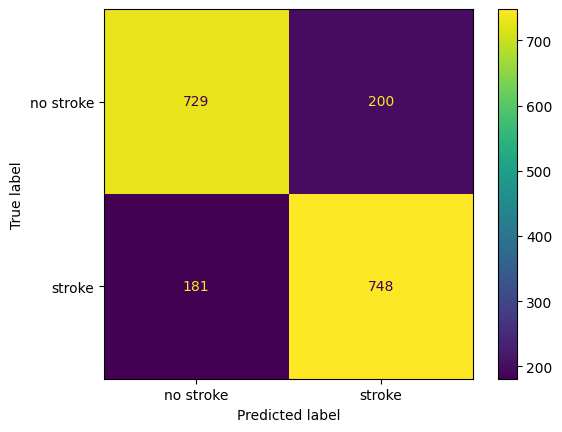

In [53]:
mlp = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate_init=0.001,
    max_iter=2000,
    random_state=42,
    early_stopping=True
)
mlp.fit(X_train_res, y_train_res)
pred = mlp.predict(X_test_res)

cm = confusion_matrix(y_test_res, pred, labels=[0,1])
tn, tp, fp, fn = cm[0][0], cm[1][1], cm[0][1], cm[1][0]

precision = tp / (tp + fp)
recall = tp / (tp + fn)
if precision + recall == 0:
    f1_score = 0.0
else:
    f1_score = 2 * precision * recall / (precision + recall)
accuracy = accuracy_score(pred, y_test_res)
roc_auc = roc_auc_score(y_test_res, pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no stroke', 'stroke'])
disp.plot()

print(f"MLP: \nF1: {f1_score:.2f},\nAcc: {accuracy:.2f},\nAUC: {roc_auc:.2f}")

In [54]:
#optimize_mlp_manually(X_train_res, y_train_res, X_test_res, y_test_res)